In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [2]:
genomes = pd.read_csv('viral_genomes.csv')

In [3]:
genomes.rename(columns = {'Genome': 'Name'}, inplace = True)

In [4]:
genomes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9458 entries, 0 to 9457
Data columns (total 15 columns):
Name                  9458 non-null object
Accession             9458 non-null object
Source information    5845 non-null object
Segm                  9458 non-null object
Length                9458 non-null object
Protein               9458 non-null object
Neighbors             9458 non-null object
Host                  9455 non-null object
Created               9458 non-null object
Updated               9458 non-null object
Classification        9458 non-null object
Extra Info            2996 non-null object
Sequence              9458 non-null object
Molecule Type         9458 non-null object
Phylogeny             9458 non-null object
dtypes: object(15)
memory usage: 1.1+ MB


In [5]:
# Clean up the length column and convert the values to ints
genomes['Length'] = genomes['Length'].apply(lambda x: int(x.replace('nt', '').replace('(', '').replace(')','')))

In [6]:
# Clean up the Phylogeny column a little bit
genomes['Phylogeny'] = genomes['Phylogeny'].apply(lambda x: x[9:-1] if x[-1] == ';' else x[9:])
genomes['Phylogeny'] = genomes['Phylogeny'].apply(lambda x: x.split(';')[1:] if len(x.split(';')) > 1 
                                                  else x.split(';'))
genomes['Phylogeny'] = genomes['Phylogeny'].apply(lambda x: ','.join(x))

In [8]:
genomes.head()

,Name,Accession,Source information,Segm,Length,Protein,Neighbors,Host,Created,Updated,Classification,Extra Info,Sequence,Molecule Type,Phylogeny
0,Hepatitis delta virus,/nuccore/13277517,NaN,-,1682,2,320,"vertebrates, human",04/29/1993,02/10/2015,Deltavirus,NaN,atgagccaagttccgaacaaggattcgcggggaggatagatcagcg...,genomic RNA,Deltavirus
1,Badger associated gemykibivirus 1,/nuccore/807743872,strain:588t,-,2112,2,-,vertebrates,04/16/2015,11/24/2015,Genomoviridae,NaN,taatactatagccatctgggacacagagcacagtcgacgtgtccct...,genomic DNA,Gemykibivirus
2,Bemisia-associated genomovirus AdDF,/nuccore/1211677462,isolate:AdDF,-,2199,2,-,invertebrates,06/27/2017,07/19/2017,Genomoviridae,NaN,taatgttatacacaaaccgtggtgtcagtgtcacctctatatagta...,genomic DNA,unclassified Genomoviridae
3,Bemisia-associated genomovirus AdO,/nuccore/1211677465,isolate:AdO,-,2211,2,-,invertebrates,06/27/2017,07/19/2017,Genomoviridae,NaN,taatattatagcccaggacacagggcacacctgtgtctatataaac...,genomic DNA,unclassified Genomoviridae
4,Bemisia-associated genomovirus NfO,/nuccore/1211677468,isolate:NfO,-,2231,2,-,invertebrates,06/27/2017,07/19/2017,Genomoviridae,NaN,taatattattctctctctcaggcagaggtagagggagttaatatag...,genomic DNA,unclassified Genomoviridae


In [19]:
genomes['Host'].value_counts()

bacteria                             2213
invertebrates                        2081
plants                               1965
vertebrates                          1318
vertebrates, human                    547
vertebrates, invertebrates, human     305
fungi                                 269
invertebrates, plants                 191
environment                           173
vertebrates, invertebrates            149
archaea                                89
algae                                  64
protozoa                               58
invertebrates, vertebrates              7
invertebrates, vertebrates, human       7
human                                   7
None                                    4
eukaryotes                              4
diatom                                  3
protozoa, vertebrates                   1
Name: Host, dtype: int64

In [24]:
genomes['Protein'] = genomes['Protein'].apply(lambda x: int(x) if x.isdigit() else np.nan)

In [25]:
genomes['Protein'].value_counts()

2.0       1084
1.0        916
3.0        488
6.0        467
5.0        342
4.0        299
7.0        212
8.0         79
9.0         71
45.0        51
10.0        42
58.0        39
46.0        38
51.0        38
55.0        37
56.0        37
49.0        37
52.0        35
79.0        34
86.0        34
54.0        33
53.0        33
50.0        33
11.0        32
47.0        32
94.0        31
57.0        30
59.0        30
67.0        29
60.0        29
          ... 
390.0        1
248.0        1
849.0        1
860.0        1
429.0        1
375.0        1
434.0        1
1120.0       1
353.0        1
350.0        1
470.0        1
979.0        1
261.0        1
182.0        1
202.0        1
327.0        1
232.0        1
1430.0       1
347.0        1
298.0        1
402.0        1
802.0        1
289.0        1
264.0        1
188.0        1
284.0        1
304.0        1
437.0        1
303.0        1
611.0        1
Name: Protein, Length: 358, dtype: int64

# Exploratory Data Analysis

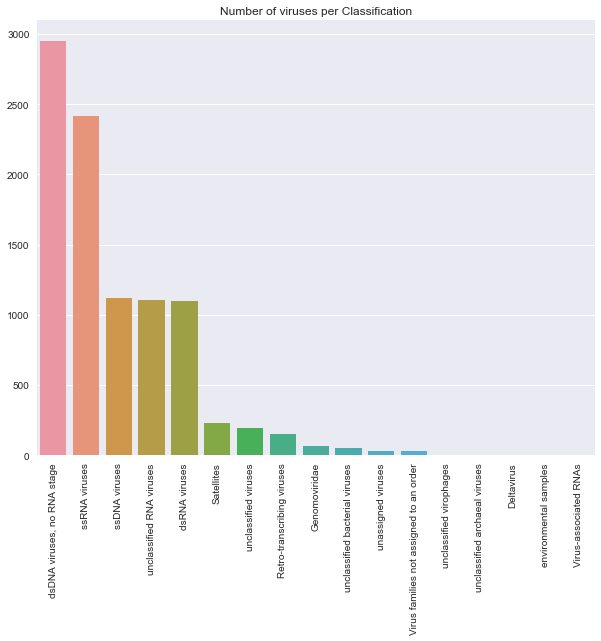

In [9]:
classifications = [item[0] for item in list(genomes['Classification'].value_counts().items())]
class_counts = [item[1] for item in list(genomes['Classification'].value_counts().items())]

plt.figure(figsize = (10,8))
virus_count_bar = sns.barplot(classifications, class_counts)
for item in virus_count_bar.get_xticklabels():
    item.set_rotation(90)
plt.title('Number of viruses per Classification')
None

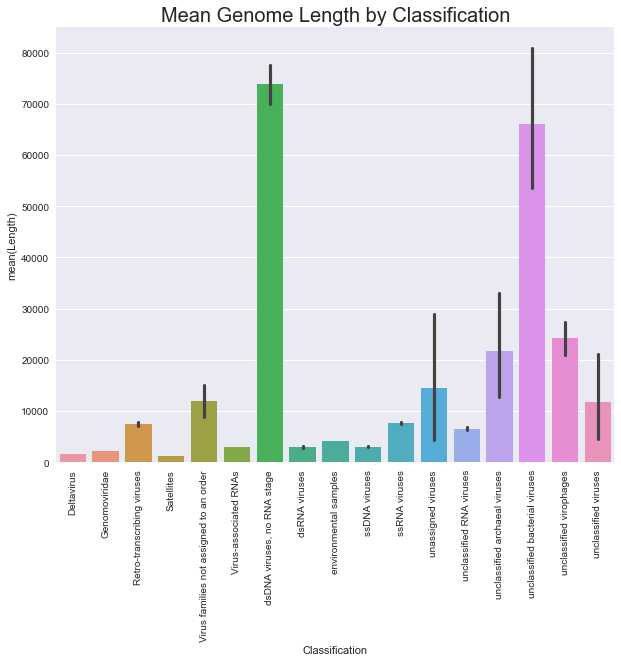

In [20]:
plt.figure(figsize = (10,8))
class_length_bar = sns.barplot(genomes['Classification'], genomes['Length'])
for item in class_length_bar.get_xticklabels():
    item.set_rotation(90)
plt.title('Mean Genome Length by Classification', fontsize=20)
None

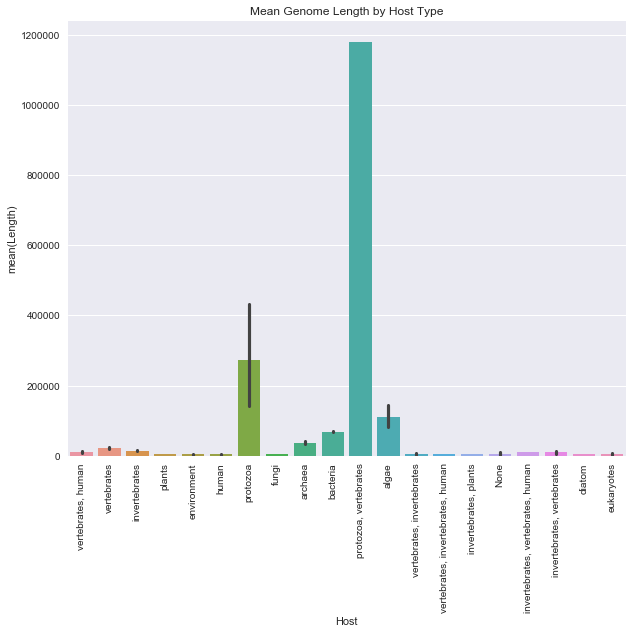

In [11]:
plt.figure(figsize = (10,8))
type_length_bar = sns.barplot(genomes['Host'], genomes['Length'])
for item in type_length_bar.get_xticklabels():
    item.set_rotation(90)
plt.title('Mean Genome Length by Host Type')
None

In [12]:
classifications

['dsDNA viruses, no RNA stage',
 'ssRNA viruses',
 'ssDNA viruses',
 'unclassified RNA viruses',
 'dsRNA viruses',
 'Satellites',
 'unclassified viruses',
 'Retro-transcribing viruses',
 'Genomoviridae',
 'unclassified bacterial viruses',
 'unassigned viruses',
 'Virus families not assigned to an order',
 'unclassified virophages',
 'unclassified archaeal viruses',
 'Deltavirus',
 'environmental samples',
 'Virus-associated RNAs']

Number per Phylogeny in Retro-transcribing viruses 
 ['Retro'] : [151] 

Number per Phylogeny in Deltavirus 
 ['Deltavirus'] : [1] 

Number per Phylogeny in environmental samples 
 [' Amalgaviridae, unclassified Amalgaviridae'] : [1] 

Number per Phylogeny in Virus-associated RNAs 
 [' Lavidaviridae'] : [1] 



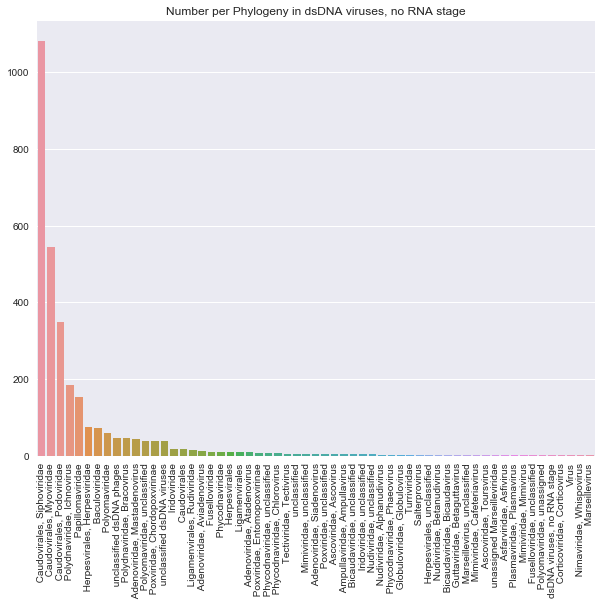

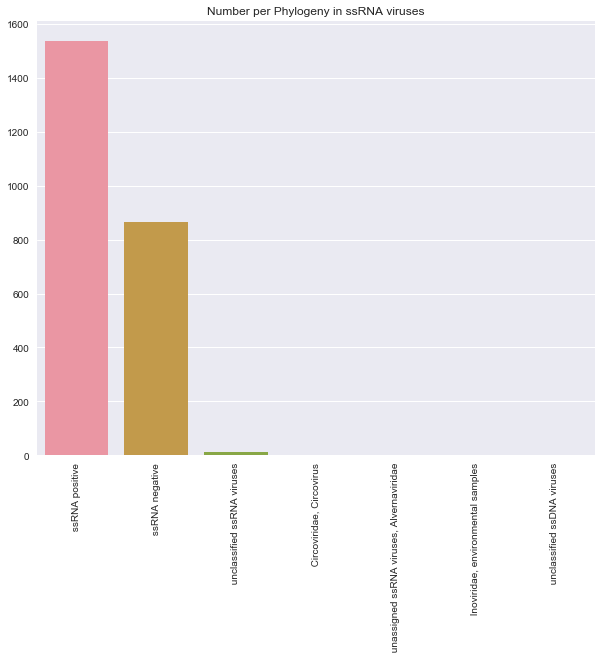

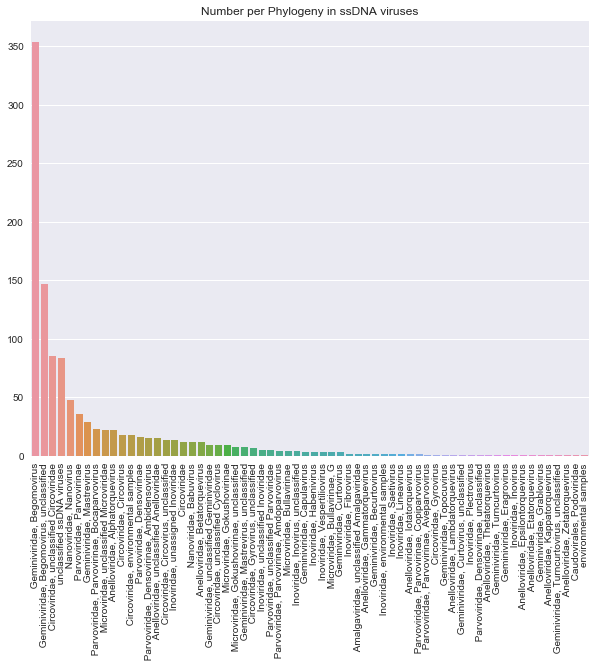

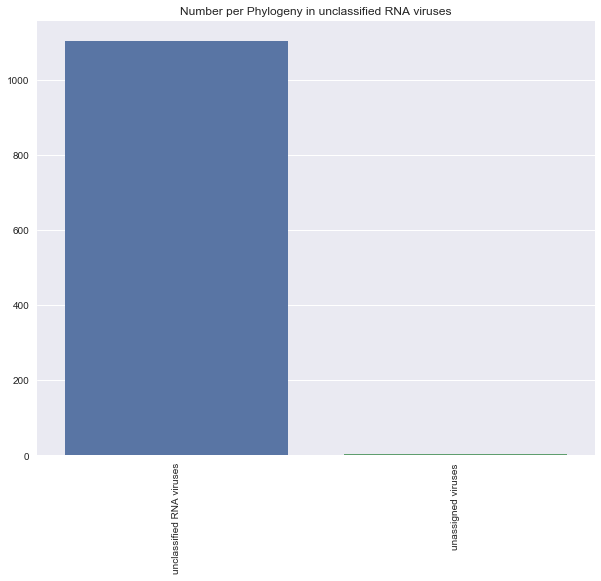

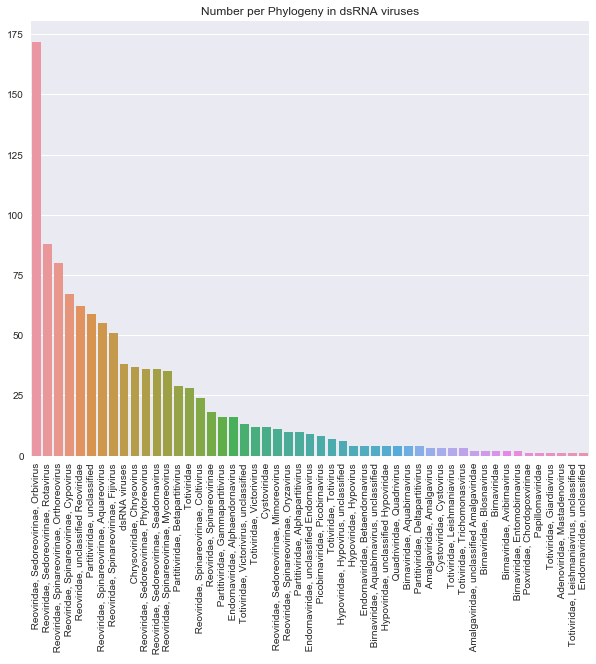

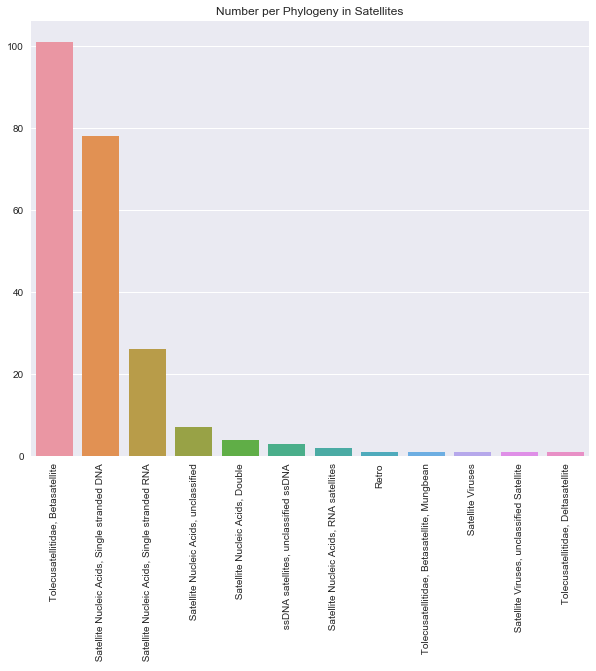

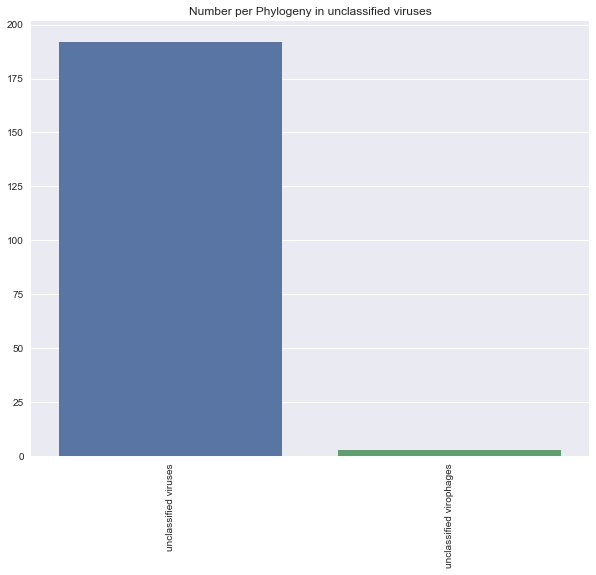

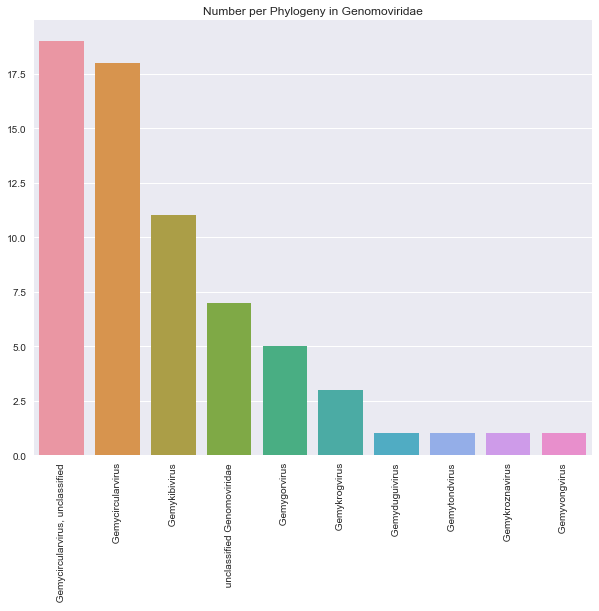

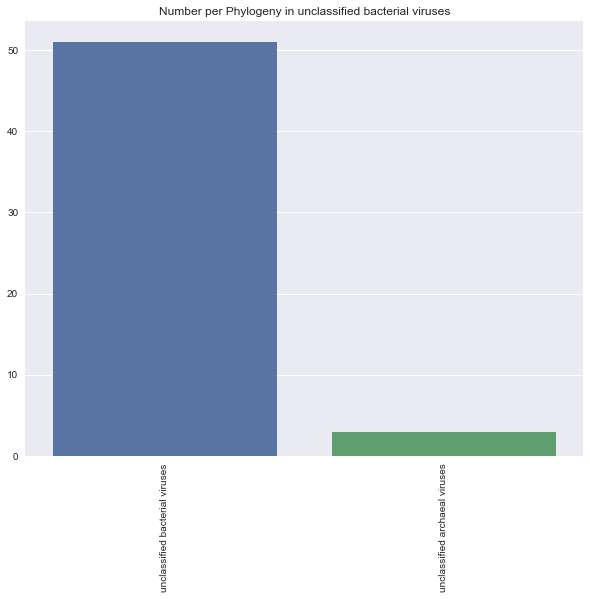

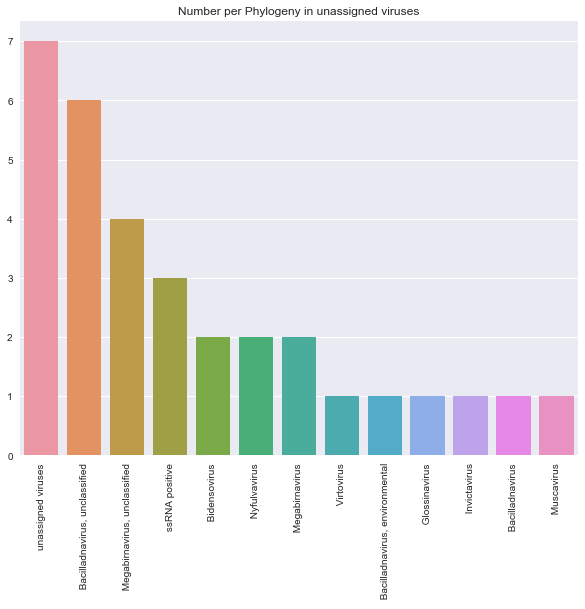

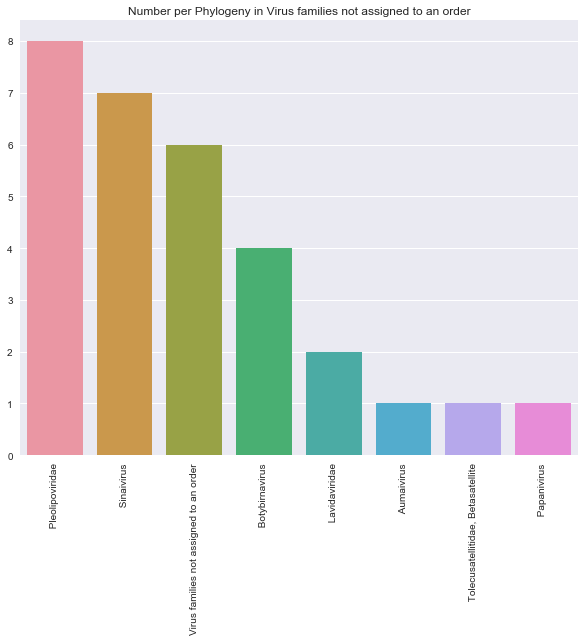

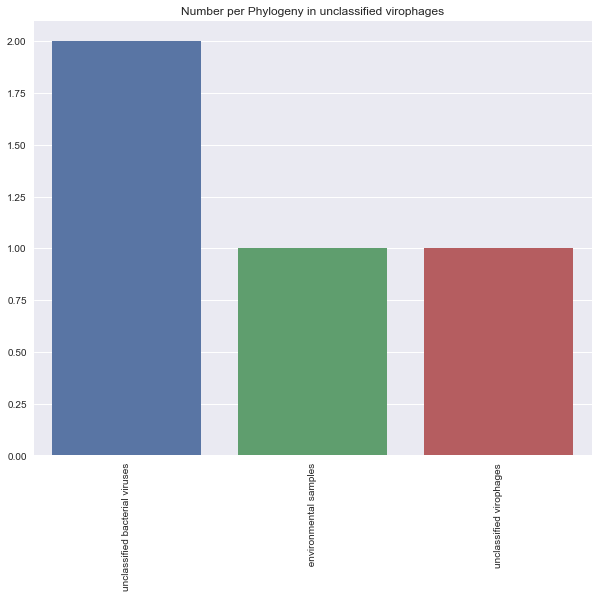

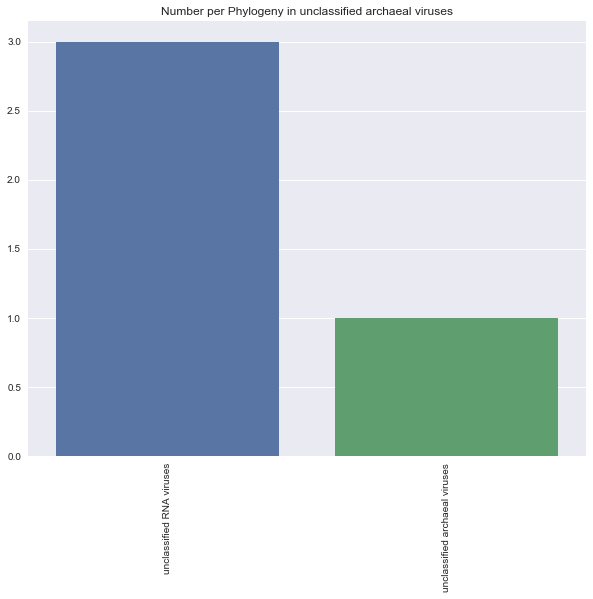

In [18]:
for classification in classifications:
    pd = genomes.loc[genomes['Classification'] == classification]
    phylogenies = [item[0] for item in list(pd['Phylogeny'].value_counts().items())]
    phylo_counts = [item[1] for item in list(pd['Phylogeny'].value_counts().items())]
    p_title = 'Number per Phylogeny in {}'.format(classification) 
    if len(phylogenies) > 1:
        plt.figure(figsize = (10,8))
        phylo_count_bar = sns.barplot(phylogenies, phylo_counts)
        for item in phylo_count_bar.get_xticklabels():
            item.set_rotation(90)
        plt.title(p_title)
        None
    else: 
        print(p_title, '\n', phylogenies,':', phylo_counts, '\n')